# 532 Lec 3 - Dash layouts and Altair interactivity

## Lecture learning goals

By the end of the lecture you will be able to:


1. Implement callbacks with multiple input and outputs
2. Use dash bootstrap components to lay out dashboard components on grid
3. Create selections within a plot in Altair
4. Link selections between plots to highlight and select data.

## Table of Contents

You can view the ToC by opening this in your local Jupyter Lab,
and downloading the ToC extension
by going to the Extension Manager tab in the left sidebar, searching for "toc", and clicking "install"
(I posted [a video about this on slack](https://ubc-mds.slack.com/archives/C24GEJS11/p1599940203406600) if you can't find the extension).

## Optional readings

- [Dash documentation](https://github.com/plotly/dash-docs)
- [Dash bootstrap components docs](https://dash-bootstrap-components.opensource.faculty.ai/docs/components)
- [Videos showing how to implement most things in Dash](https://www.youtube.com/channel/UCqBFsuAz41sqWcFjZkqmJqQ)
- [Dash app gallery](https://dash-gallery.plotly.host/Portal/). Below are links to the source code of the apps that I think can be the most useful for you to check out:

Instructive:

- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-aix360-heart (Cards, layout)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-cuml-umap (sliders, single fig update)
- https://dash-bootstrap-components.opensource.faculty.ai/examples/simple-sidebar/ (sidebar with link to pages)
- https://dash-bootstrap-components.opensource.faculty.ai/examples/iris/ (grouped options in cards)
    
Advanced:

- https://github.com/plotly/dash-sample-apps/blob/master/apps/dash-nlp/app.py (layout, sidebar, tabs, NLP)
- https://github.com/plotly/dash-sample-apps/blob/master/apps/dash-clinical-analytics/app.py (Layout, advanced viz)
- https://github.com/plotly/dash-sample-apps/blob/master/apps/dash-daq-iv-tracer/app.py (DAQ widgets)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-financial-report (Multi-page app)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-interest-rate (Database, train ML model)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-live-model-training (streaming live data, [also see the docs](https://dash.plotly.com/live-updates))

For fun:

- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-gpt3-chatbot (gpt3 chatbot)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-gpt3-bars (Auto-create a bar chart from an description in English via GPT3)

---

## Simplifying the callbacks when using an Iframe

*This content is also included at the end of the notes from the previous lectures*

The above works perfectly fine,
but it feels a bit inelegant
to have a separate function just for the callback decorator.
The reason for this above is that we set `srcDoc` to `plot_altair()`,
so we need this function to be defined before the iframe is referenced.
We could work around this
by not specifying any argument to the `srcDoc` parameter
when creating the Iframe:

```python
html.Iframe(
    id='scatter',
    style={'border-width': '0', 'width': '100%', 'height': '400px'}),
```

Now we could move the `plot_altair()` function down under the `app.layout`
and use the callback decorator directly on this function 
instead of having a separate `update_output` function:

```python
@app.callback(
    Output('scatter', 'srcDoc'),
    Input('xcol-widget', 'value'))
def plot_altair(xcol):
    chart = alt.Chart(cars).mark_point().encode(
        x=xcol,
        y='Displacement',
        tooltip='Horsepower').interactive()
    return chart.to_html()
```

This looks neater,
and is more similar to how dash is used with plotly
where the iframe is not needed.
But we have one big issue.
The first time the app loads,
the iframe will be empty 
and it will not show an Altair plot
until the dropdown is used to select a value.
This is not good because we often want our app to tell a story by default.
Luckily it is easy to fix.
We can trigger a callback from the dropdown
by setting its default value,
which will act just as if we had clicked it manually
and call the function that creates the Altair plot!

Our full app now looks like this:

```python
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import altair as alt
from vega_datasets import data


# Read in global data
cars = data.cars()

# Setup app and layout/frontend
app = dash.Dash(__name__,  external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])
app.layout = html.Div([
    html.Iframe(
        id='scatter',
        style={'border-width': '0', 'width': '100%', 'height': '400px'}),
    dcc.Dropdown(
        id='xcol-widget',
        value='Horsepower',  # REQUIRED to show the plot on the first page load
        options=[{'label': col, 'value': col} for col in cars.columns])])

# Set up callbacks/backend
@app.callback(
    Output('scatter', 'srcDoc'),
    Input('xcol-widget', 'value'))
def plot_altair(xcol):
    chart = alt.Chart(cars).mark_point().encode(
        x=xcol,
        y='Displacement',
        tooltip='Horsepower').interactive()
    return chart.to_html()

if __name__ == '__main__':
    app.run_server(debug=True)
```

The comments explain what each section is for,
and are worth keeping in mind for developing your own app.
The reason we load the data first
is that it is often used in the app layout,
for example to populate the options of the dropdown.
As a final improvement,
you can see that I changed how the width and height are specified,
to ensure that they are expanded automatically as the chart grows
(I mentioned in the last lecture that there are some issues when using `%`,
and here I use `vw` instead which is another type of unit with less restrictions).


**This is the app skeleton I recommend using for plots in your dashboard**,
but remember that it is possible to use what we did last lecture also
in case you need to workaround some particularity
with how you want your app to work.

# Multiple inputs to the same callback function

What if we want to control both the x and y-axis via dropdown menus?
We can add a second dropdown widgets to the app layout 
by copying to code for the first one and changing its ID and default value.

```python
dcc.Dropdown(
    id='ycol-widget',
    value='Displacement',
    options=[{'label': col, 'value': col} for col in cars.columns])
```

Then we add a second input to the callback decorator,
and the plot function:

```python
@app.callback(
    Output('scatter', 'srcDoc'),
    Input('xcol-widget', 'value'),
    Input('ycol-widget', 'value'))
def plot_altair(xcol, ycol):
    chart = alt.Chart(cars).mark_point().encode(
        x=xcol,
        y=ycol,
        tooltip='Horsepower').interactive()
    return chart.to_html()
```

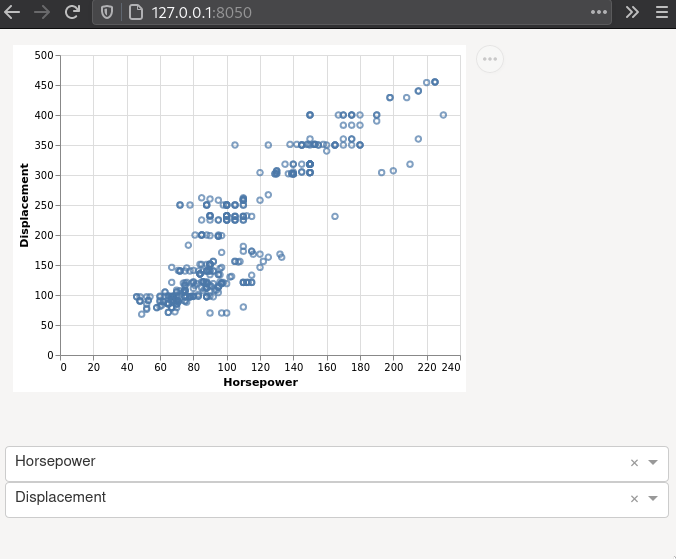

# Multiple outputs from the same callback function

In addition to showing the scatter plot,
we might also want to show some key numbers of interest.
Let's see how to display the mean from the selected x-axis column
just under the plot.
For this, we need to do two things:
First calculate and return the mean value from the plot function,
and second define an output area and link it to the plot function
As the output area,
we can use a Div as we saw in the last lecture
and the decorated function will now take an additional output in the decorator
and return two values instead of one,
which looks like this:

```python
@app.callback(
    Output('scatter', 'srcDoc'),
    Output('mean-x-div', 'children'),  # This is the ID of our new output Div
    Input('xcol-widget', 'value'),
    Input('ycol-widget', 'value'))
def plot_altair(xcol, ycol):
    chart = alt.Chart(cars).mark_point().encode(
        x=xcol,
        y=ycol,
        tooltip='Horsepower').interactive()
    return chart.to_html(), f'The mean of {xcol} is {cars[xcol].mean().round(1)}'
```

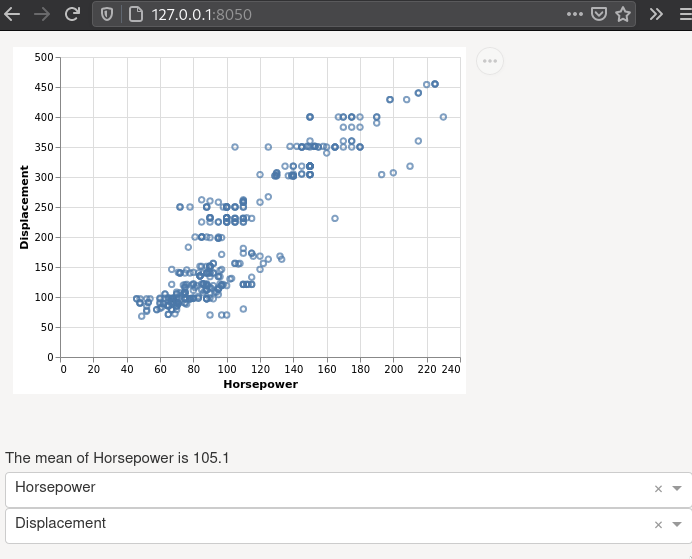

For more advanced call backs such as chaining
and apps with a "state" where you control *when* the values are read
(e.g. press of a button),
see [the callback section of the docs](https://dash.plotly.com/basic-callbacks).

## Adding widget labels and whitespace

Since we have multiple dropdowns,
it is good to add labels for them with `html.Label`.
I will also add some whitespace with `html.Br` (break),
to make it look nicer.
Our entire app now looks like this:

```python
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import altair as alt
from vega_datasets import data


# Read in global data
cars = data.cars()

# Setup app and layout/frontend
app = dash.Dash(__name__,  external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])
app.layout = html.Div([
    html.Iframe(
        id='scatter',
        style={'border-width': '0', 'width': '100%', 'height': '400px'}),
    html.Div(id='mean-x-div'),
    html.Br(),
    html.Label([
        'X column',
        dcc.Dropdown(
            id='xcol-widget',
            value='Horsepower',  # REQUIRED to show the plot on the first page load
            options=[{'label': col, 'value': col} for col in cars.columns])]),
    html.Label([
        'Y column',
        dcc.Dropdown(
            id='ycol-widget',
            value='Displacement',  # REQUIRED to show the plot on the first page load
            options=[{'label': col, 'value': col} for col in cars.columns])])])

# Set up callbacks/backend
@app.callback(
    Output('scatter', 'srcDoc'),
    Output('mean-x-div', 'children'),
    Input('xcol-widget', 'value'),
    Input('ycol-widget', 'value'))
def plot_altair(xcol, ycol):
    chart = alt.Chart(cars).mark_point().encode(
        x=xcol,
        y=ycol,
        tooltip='Horsepower').interactive()
    return chart.to_html(), f'The mean of {xcol} is {cars[xcol].mean().round(1)}'

if __name__ == '__main__':
    app.run_server(debug=True)
```

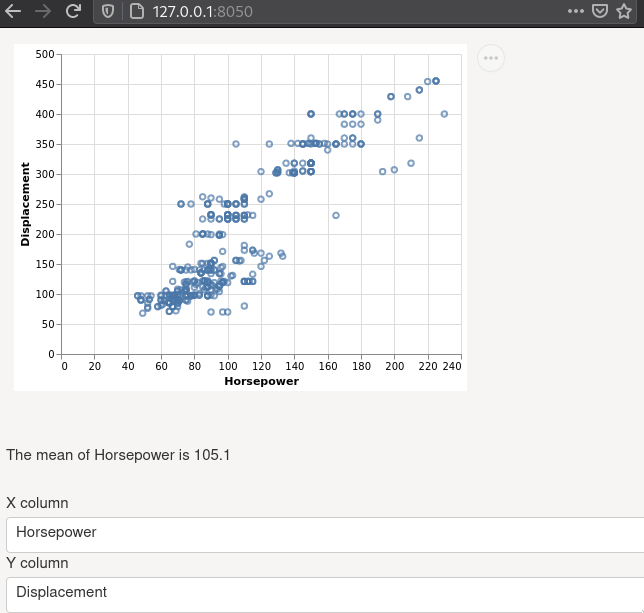

Starting to look good, let's make it look even nicer!

# Dash bootstrap components

Bootstrap is the world's most popular frontend framework,
providing ready-to-use templates for css and javascript,
that save developers time.
In dash,
it is a community driven component
and we will mostly use it to facilitate laying out our app in a grid pattern.
However,
you are free to use [any of its components](https://dash-bootstrap-components.opensource.faculty.ai/docs/components/form/) if you wish.

Currently,
our app looks like this in a full screen window:

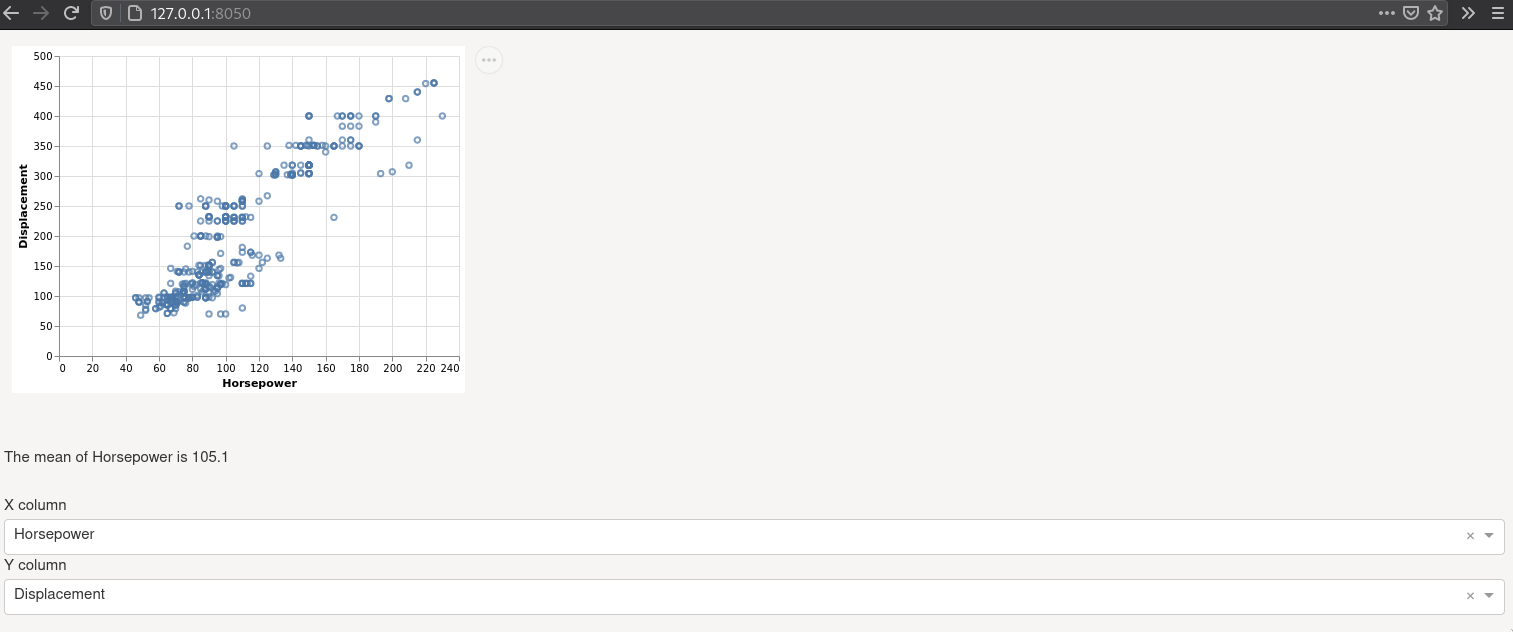

Less than fantastic...
There is no limit on how wide widgets expand,
which makes it look really stretched out and ugly in fullscreen mode.
Bootstrap's default layout component is called a container,
and it will add whitespace on each side of the web page.
Just changing the top level `html.Div` in the app's layout
to the bootstrap container makes our app look like this instead.

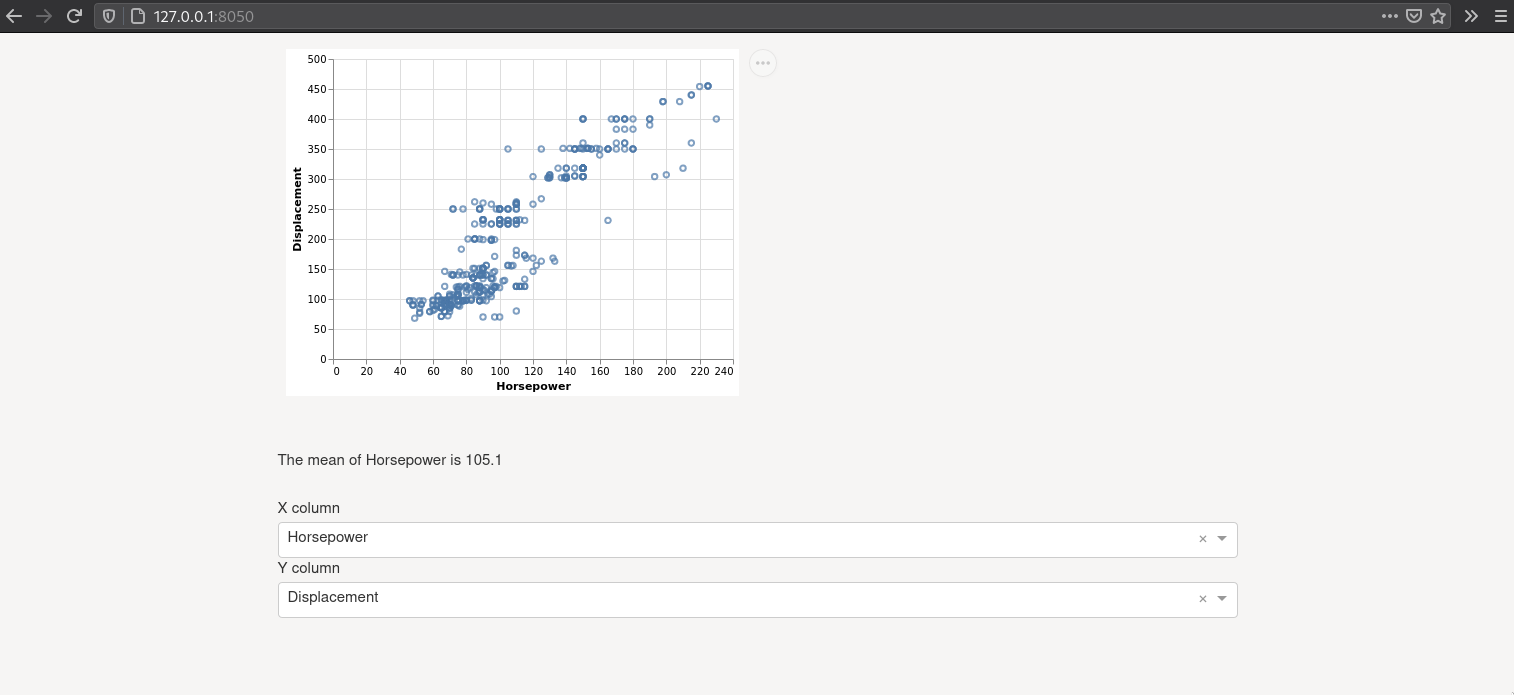

Much better!
This is a great width, especially when we start adding columns to the app.
If you have many columns in your app and want it to stretch the full width of the screen,
you can set `fluid=True` in the container,
and we will always be using it instead of the top level div from now on.
We can also adjust the exact whitespace on the sides via the `max-width` css-class,
e.g. `style={'max-width': '85%'}`.
Just make sure to leave enough whitespace to frame your app
and not make it look stretched out
(unless creating an intentional effect by doing so).

Bootstrap's layout consists of a list of rows,
and each row can contain a list of columns.
This is how the grid is created,
and [there are some great illustrations in the docs](https://dash-bootstrap-components.opensource.faculty.ai/docs/components/layout/) to make it more clear,
including this one:

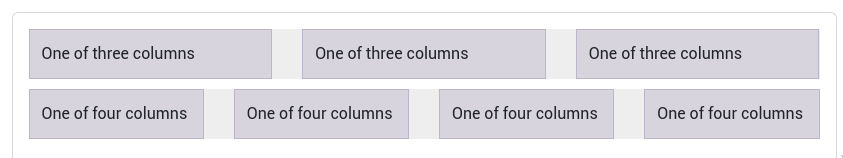

This is what the app layout part looks like
after we have rewritten it with bootstrap's columns and rows.
The stylesheet line is important,
in order for any bootstrap components to work
(including the container above),
we must use their stylesheet
and will be doing so in all our code from now on.
To replicate the layout we have already in the bootstrap grid,
we would create a single row,
with a single column
holding all our widgets
(you will need to refresh your browser page
to see CSS changes like this one).
I have taken out the labels and the break here so it is easier to follow.

```python
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.Iframe(
                id='scatter',
                style={'border-width': '0', 'width': '100%', 'height': '400px'}),
            dcc.Dropdown(
                id='xcol-widget',
                value='Horsepower',  # REQUIRED to show the plot on the first page load
                options=[{'label': col, 'value': col} for col in cars.columns]),
            dcc.Dropdown(
                id='ycol-widget',
                value='Displacement',  # REQUIRED to show the plot on the first page load
                options=[{'label': col, 'value': col} for col in cars.columns])])])])

```

# Laying out our app in a grid pattern instead of a single vertical column

Now let's put the two dropdown widgets in their own column next to the plot.
**If you don't see the two columns,
refresh your browser window to read in the bootstrap css properly**

```python
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(
            html.Iframe(
                id='scatter',
                style={'border-width': '0', 'width': '100%', 'height': '400px'})),
        dbc.Col([
            dcc.Dropdown(
                id='xcol-widget',
                value='Horsepower',  # REQUIRED to show the plot on the first page load
                options=[{'label': col, 'value': col} for col in cars.columns]),
            dcc.Dropdown(
                id='ycol-widget',
                value='Displacement',  # REQUIRED to show the plot on the first page load
                options=[{'label': col, 'value': col} for col in cars.columns])])])])
```

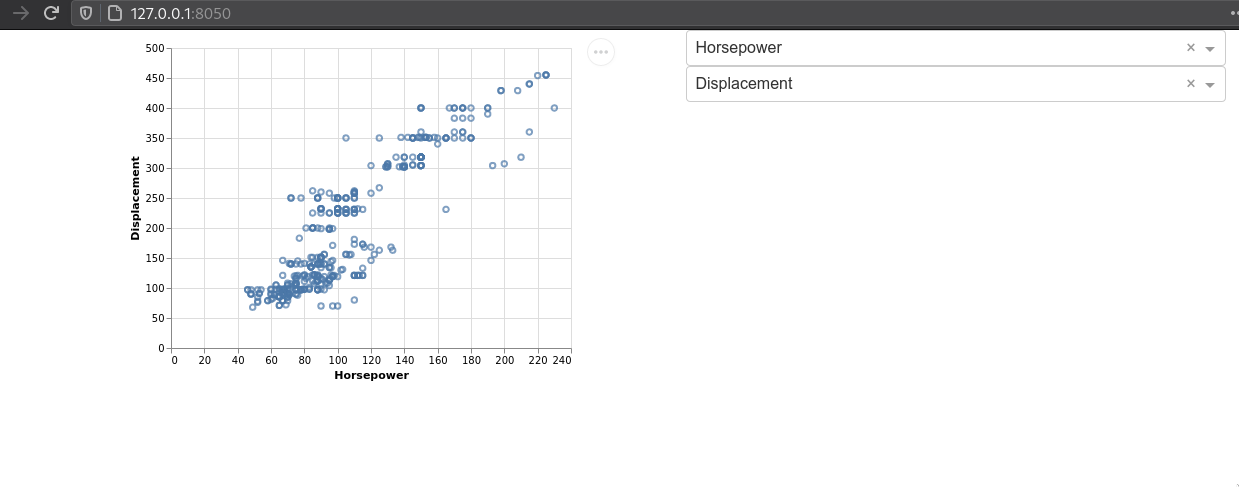

The widget column does not need to be as wide as the plot column.
Bootstrap rows consist of a total of 12 columns width units.
If we don't specify a width,
the columns will expand automatically,
so in our case, each of the two columns has expanded to 6 width units.
We can use the `width` parameter to set an exact size for a column.
However,
it is usually better to use the `md` ("medium") parameter,
which sets a specific size for computer screens,
but let's bootstrap figure out the widths on devices with smaller screens,
such as cell phones.

We will also add and H1 heading
and move the widget column above the plot in the code,
so that they show up on the left in the dashboard.

```python
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import altair as alt
from vega_datasets import data
import dash_bootstrap_components as dbc


# Read in global data
cars = data.cars()

# Setup app and layout/frontend
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container([
    html.H1('My mudplank'),
    dbc.Row([
        dbc.Col([
            dcc.Dropdown(
                id='xcol-widget',
                value='Horsepower',  # REQUIRED to show the plot on the first page load
                options=[{'label': col, 'value': col} for col in cars.columns]),
            dcc.Dropdown(
                id='ycol-widget',
                value='Displacement',  # REQUIRED to show the plot on the first page load
                options=[{'label': col, 'value': col} for col in cars.columns])],
            md=4),
        dbc.Col(
            html.Iframe(
                id='scatter',
                style={'border-width': '0', 'width': '100%', 'height': '400px'}))])])
# Set up callbacks/backend
@app.callback(
    Output('scatter', 'srcDoc'),
    Input('xcol-widget', 'value'),
    Input('ycol-widget', 'value'))
def plot_altair(xcol, ycol):
    chart = alt.Chart(cars).mark_point().encode(
        x=xcol,
        y=ycol,
        tooltip='Horsepower').interactive()
    return chart.to_html()

if __name__ == '__main__':
    app.run_server(debug=True)
```

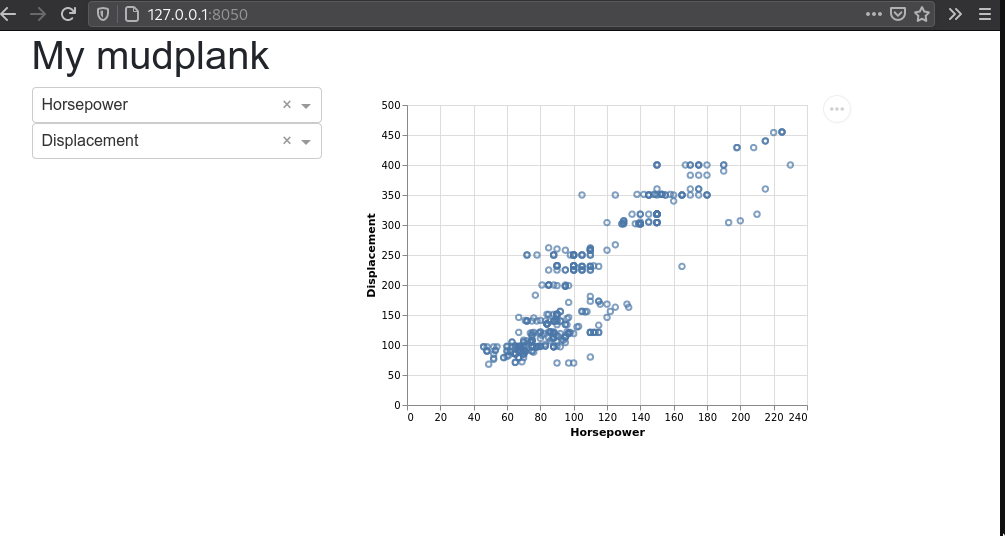

If we wanted to add an outline or background on the widget controls,
we could style the column with CSS,
the same way we styled the HTML text in the last lecture.
We could add a styling dictionary similar to this:

```python
md=4, style={'border': '1px solid #d3d3d3', 'border-radius': '10px'}),
```

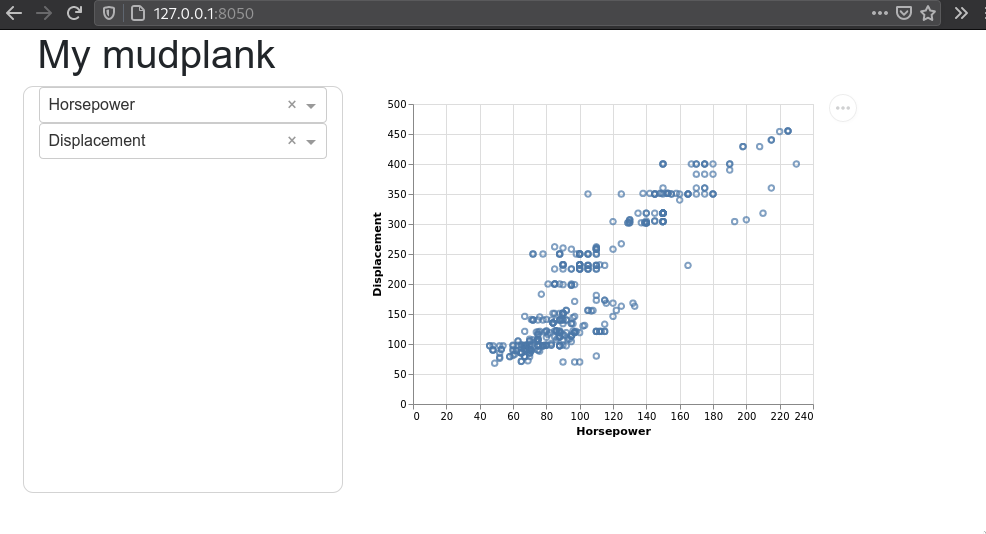

## Tabs

Tabs can be used to switch between completely different sections
that you might not want to display at the same time in your dashboard.
A tab could also be a good place to have help instructions for how to use the dashboard
or to have another set of plots.

```python
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = html.Div([
    dbc.Tabs([
        dbc.Tab('Some text', label='Tab one'),
        dbc.Tab('Some other text', label='Tab two')])])
```

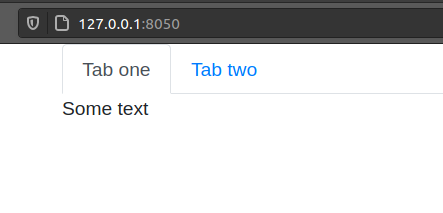

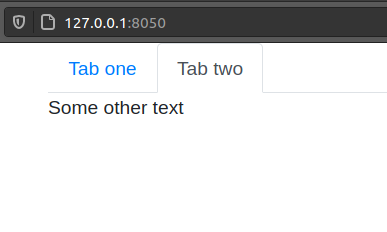

You could use HTML and Markdown properties inside tabs,
just as we used them in the layout:

```python
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container([
    dbc.Tabs([
        dbc.Tab([
            html.H1('A heading'),
            html.P('With a help paragraph')],
            label='Tab one'),
        dbc.Tab('Some other text', label='Tab two')])])
```

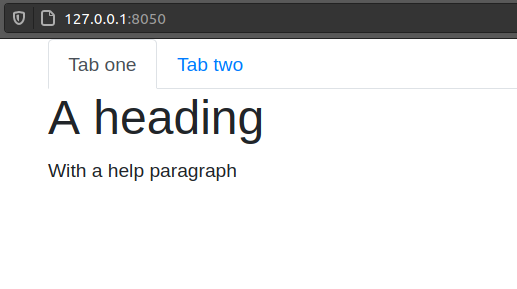

There are also Tabs in the dash core components module.
However there are not styled as nicely as the bootstrap ones
and stretch out more than you would like in most cases:

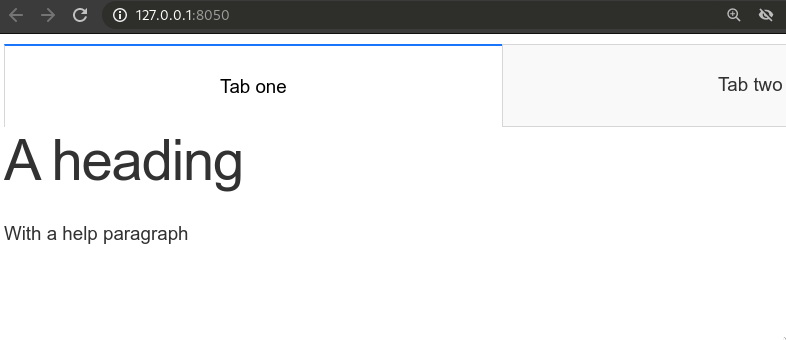

# Interactivity between plots using Altair

So far we have discussed how to use dash widgets
to let the user control which columns in the dataframe are used for plotting.
So the widget drives the event and the plots respond to them.
Another type of interactivity is driven from the plots themselves,
such as selections,
and can influence other plots
(but not dash components since Altair does not broadcast signals for this (yet)).

## Interval selections

One of the unique features of Altair
is that it does not only define a grammar of graphics,
but also a grammar of interactivity,
which makes it intuitive to add many of the plot-to-plot interactions.
This interactivity is specified in the Altair/Vega-lite spec,
so when you export your plot to HTML files,
the interactivity is still there in the HTML and JS code,
even after you shut down your Python/JupyterLab.
This is called client side interactivity and is great for emailing someone an interactive chart.
In contrast,
the dash components require an active Python server running
for their interactivity.

In [106]:
import altair as alt
from vega_datasets import data


cars = data.cars()

alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon')

alt.Chart(...)

Let's add a selection that lets us drag and drop with the mouse
to create an interval of selected points.
An interval selection is often called a "brush"
and connecting two plots is often referred to as "linked brushing".

In [107]:
brush = alt.selection_interval()
 
(alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon')
.add_selection(brush))

alt.Chart(...)

## Highlighting points with selections

It would be nice if the points were highlighted when selected.
Altair has a built in `if/else` function called `condition`
that checks if an event is present (such as selection) 
and then lets us define what to do if it is `True` and if it is `False`.

`alt.condition(check-this, if-true-do-this, if-false-do-this)`

In [46]:
brush = alt.selection_interval()
 
(alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.value('lightgray')))
.add_selection(brush))

alt.Chart(...)

We could change along which dimensions the selection is active.
By default is is both x and y for scatter plots.

In [114]:
brush = alt.selection_interval(encodings=['x'])
 
(alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.value('lightgray')))
.add_selection(brush))

alt.Chart(...)

## Linking selections across plots

Selections are automatically linked between plots.
This is great for comparing the same observations across multiple dimensions.

In [60]:
brush = alt.selection_interval()
 
points = (alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.value('lightgray')))
.add_selection(brush))

points | points.encode(y='Weight_in_lbs')

alt.HConcatChart(...)

There is only one interval selection above,
if I start dragging in another plot,
the first selection disappears.
I can modify this behavior
and change it so that each subplot gets its own selection
and that points within any section are highlighted within all plots
by setting `resolve='union'`.

In [94]:
brush = alt.selection_interval(resolve='union')  # The default is 'global'

points = (alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.value('lightgray')))
.add_selection(brush))

points | points.encode(y='Weight_in_lbs')

alt.HConcatChart(...)

I could modify this behavior so that only points that fall within
the intersection of *all* the selections are highlighted.

In [92]:
brush = alt.selection_interval(resolve='intersect')
 
points = (alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.value('lightgray')))
.add_selection(brush))

points | points.encode(y='Weight_in_lbs')

alt.HConcatChart(...)

## Click selections

In addition to interval/drag interactivity,
there is also interactivity via clicking.
Let's add add a bar chart that changes the opacity of bars
when not clicked.
You can hold shift to select multiple.

Since our plot becomes taller here,
you also might need to change the height of your iframe.
Note that setting the iframe height to `100vh` instead of pixels
*should* dynamically resize it as it gets bigger,
but I have noticed that in some browsers it makes them too tall,
pushing away anything under it.
You can try this (especially if there is nothing under your plot),
but make sure to test in different browsers.

In [69]:
brush = alt.selection_interval()
click = alt.selection_multi()
 
points = (alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.value('lightgray')))
.add_selection(brush))

bars = (alt.Chart(cars).mark_bar().encode(
    x='count()',
    y='Origin',
    color='Origin',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2)))
.add_selection(click))

points & bars

alt.VConcatChart(...)

## Linking selection on charts with different encodings

It would be cool if selection in one chart
was reflected in the other one...
Let's link the charts together!
For the bar chart selector,
we need to specify which field/column
we should be selecting on since the x and y axis are not the same
between the two plots so Altair can't link them automatically
like the two scatters with the same axes.

In [108]:
brush = alt.selection_interval()
click = alt.selection_multi(fields=['Origin'])
# `encodings` could also be used like this
# click = alt.selection_multi(encodings=['y'])

points = (alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.value('lightgray')),
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2)))
.add_selection(brush))

bars = (alt.Chart(cars).mark_bar().encode(
    x='count()',
    y='Origin',
    color='Origin',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2)))
.add_selection(click))

points & bars

alt.VConcatChart(...)

## Legend selections

It is often nice to include legend interactivity in scatter plots.
For this we could use the same technique as above
and specify that we want to bind it to the legend.
We also need to add the selection to the combined chart
instead of to the bar chart
since the legend belongs to both of them.

In [110]:
brush = alt.selection_interval()
click = alt.selection_multi(fields=['Origin'], bind='legend')
 
points = (alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.value('lightgray')),
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2)))
.add_selection(brush))

bars = (alt.Chart(cars).mark_bar().encode(
    x='count()',
    y='Origin',
    color='Origin',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2))))

(points & bars).add_selection(click)

alt.VConcatChart(...)

## Filtering data based on a selection

Another useful type of interactivity is to actually filter the data
based on a selection,
rather than just styling the graphical elements differently as we have done so far.
We can do this by adding `transform_filter(brush)` to out bar plot.
We mention `transform_filter` briefly in 531,
they can perform similar filter operations as pandas,
but are not as powerful in general
so they are best used for operations like this where we can't use pandas.
This type of interaction is sometimes called a dynamic query.

In [119]:
brush = alt.selection_interval()
click = alt.selection_multi(fields=['Origin'], bind='legend')
 
points = (alt.Chart(cars).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.value('lightgray')),
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2)))
.add_selection(brush))

bars = (alt.Chart(cars).mark_bar().encode(
    x='count()',
    y='Origin',
    color='Origin',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2)))
   .transform_filter(brush))

(points & bars).add_selection(click)

alt.VConcatChart(...)

## Binding selection to other chart attributes

We can also bind the selection to other attributes of our plot.
For example,
a selection could bound to the domain of the scale which sets the axis range.
This way one chart could be used as a minimap to navigate another chart.

In [120]:
source = data.sp500.url

base = alt.Chart(source).mark_area().encode(
    x = 'date:T',
    y = 'price:Q')

brush = alt.selection_interval(encodings=['x'])
lower = base.properties(height=60).add_selection(brush)

upper = base.encode(alt.X('date:T', scale=alt.Scale(domain=brush)))

upper & lower

alt.VConcatChart(...)

# Extracurricular

These sections are optional,
but can be useful.
Especially the cards,
I will try to go over these next lecture if I have time,
but I want to include them already here in case I don't or you need them earlier.

## Cards

If you have some key values that you want to highlight,
you can use bootstrap cards.
Divs could also fill the purpose,
unless you want the extra styling options provided in the cards.
We could write any text and use HTML elements inside cards.

```python
dbc.Col([
    dbc.Card(dbc.CardBody(html.H5('Key value'))),
    html.Iframe(
        id='scatter',
        style={'border-width': '0', 'width': '100%', 'height': '400px'})])])])
```

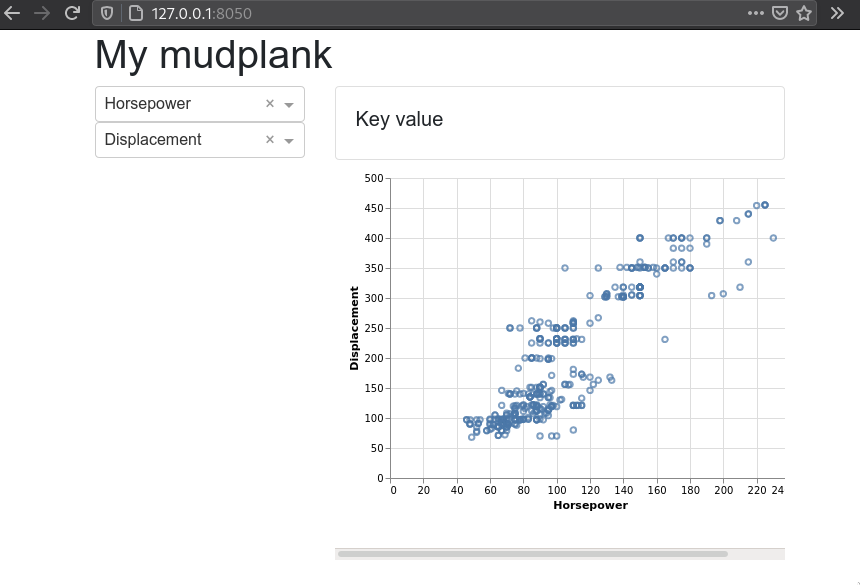

They could also be used as an output are for a calculation,
just like we saw we the div earlier.
Cards [have many styling options available to them](https://dash-bootstrap-components.opensource.faculty.ai/docs/components/card/),
some of them are displayed below.
Here we are also nesting rows inside columns
to be able to put the cards next to each other.

```python
dbc.Col([
    dbc.Row([
        dbc.Col(
            dbc.Card(
                dbc.CardBody(html.H5('Key value')),
                color='warning')),
        dbc.Col(
            dbc.Card(
                dbc.CardBody(html.H5('Key value')),
                color='info', inverse=True, style={'text-align': 'center'}))]),
    html.Iframe(
        id='scatter',
        style={'border-width': '0', 'width': '100%', 'height': '400px'})])])])
```

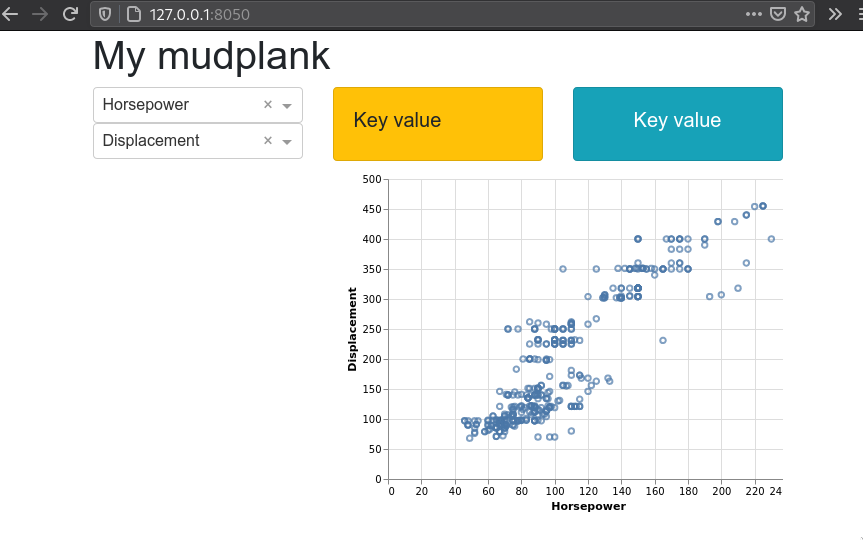

Full app:

```python
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import altair as alt
from vega_datasets import data
import dash_bootstrap_components as dbc


# Read in global data
cars = data.cars()

# Setup app and layout/frontend
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container([
    html.H1('My mudplank'),
    dbc.Row([
        dbc.Col([
            dcc.Dropdown(
                id='xcol-widget',
                value='Horsepower',  # REQUIRED to show the plot on the first page load
                options=[{'label': col, 'value': col} for col in cars.columns]),
            dcc.Dropdown(
                id='ycol-widget',
                value='Displacement',  # REQUIRED to show the plot on the first page load
                options=[{'label': col, 'value': col} for col in cars.columns])],
            md=4),
        dbc.Col([
            dbc.Row([
                dbc.Col(
                    dbc.Card(
                        dbc.CardBody(html.H5('Key value')),
                        color='warning')),
                dbc.Col(
                    dbc.Card(
                        dbc.CardBody(html.H5('Key value')),
                        color='info', inverse=True, style={'text-align': 'center'}))]),
            html.Iframe(
                id='scatter',
                style={'border-width': '0', 'width': '100%', 'height': '400px'})])])])
# Set up callbacks/backend
@app.callback(
    Output('scatter', 'srcDoc'),
    Input('xcol-widget', 'value'),
    Input('ycol-widget', 'value'))
def plot_altair(xcol, ycol):
    chart = alt.Chart(cars).mark_point().encode(
        x=xcol,
        y=ycol,
        tooltip='Horsepower').interactive()
    return chart.to_html()

if __name__ == '__main__':
    app.run_server(debug=True)
```    

## Using markdown instead of HTML

If you don't require exact control over HTML styling,
you can skip it altogether
and use the Markdown class from `dash_core_components` instead.

```python
import dash_core_components as dcc

dcc.Markdown('''
#### Dash and Markdown

Dash supports [Markdown](http://commonmark.org/help).

Markdown is a simple way to write and format text.
It includes a syntax for things like **bold text** and *italics*,
[links](http://commonmark.org/help), inline `code` snippets, lists,
quotes, and more.
''')
```

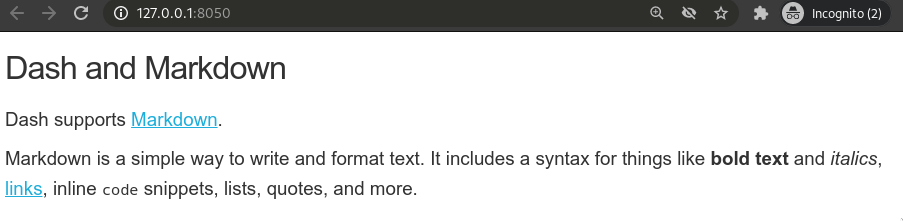

The Markdown class has a stylesheet built in,
so we don't need to be explicitly set it as above.
Our entire `app.py` now looks like this.

```python
import dash
import dash_core_components as dcc


app = dash.Dash(__name__)

app.layout = dcc.Markdown('''
#### Dash and Markdown

Dash supports [Markdown](http://commonmark.org/help).

Markdown is a simple way to write and format text.
It includes a syntax for things like **bold text** and *italics*,
[links](http://commonmark.org/help), inline `code` snippets, lists,
quotes, and more.
''')

if __name__ == '__main__':
    app.run_server(debug=True)
```